Issue described here has been found to be caused by cross-talk between nearby amplifiers. A report by Alistair Glasse (MIRI-TR-00040-ATC_FM_Electronic_Ghosts.pdf), shared in 2011, describes the effect observed here in more detail. This notebook illustrate the state of affairs between subsequent MIRI test campaigns. We show that in the FM and CV2 test campaigns the cross-talk is very high. A change in the bias voltage (Vssout) introduced prior to the CV3 campaign has alleviated the cross-talk past that point. (Question to keep in mind: How did an increase in the bias voltage affect other aspects of MIRI calibration?)

In [1]:
# load python functions and modules
import funcs
import mrsobs
from distortionMaps import d2cMapping

import numpy as np
import itertools
from scipy.interpolate import interp1d
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib notebook

In [2]:
# set user directories
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir   = workDir+'cdp_data/CDP8/'
d2cMapDir = workDir+'notebooks/distortionMaps/'

band = '1A'
campaigns = ['FM','CV2','CV3','OTIS'] # ['FM','CV2','CV3','OTIS']

**Let's load the LVL1 data**

In [3]:
sci_exp_hdu,sci_exp_ramp = {},{}
nints,ngroups,frame_delta_time = {},{},{}
for campaign in campaigns:
    sci_exp_filename   = mrsobs.MIRI_internal_calibration_source(workDir+'{}_data/LVL1/'.format(campaign),band,campaign=campaign,output='filename')
    sci_exp_hdu[campaign]   = fits.open(sci_exp_filename.replace('_LVL2',''))
    sci_exp_ramp[campaign]  = (sci_exp_hdu[campaign][0].data).astype('float')
    
    nints[campaign] = sci_exp_hdu[campaign][0].header['NINT']
    ngroups[campaign] = sci_exp_hdu[campaign][0].header['NGROUP']
    frame_delta_time[campaign] = sci_exp_hdu[campaign][0].header['TFRAME']
    
    print '{} test campaign obs params: {} ints, {} groups, {} seconds between frames'.format(campaign,nints[campaign],ngroups[campaign],frame_delta_time[campaign])

#-- print header
# campaign = 'FM'
# print(repr(sci_exp_hdu[campaign][0].header))

FM test campaign obs params: 5 ints, 20 groups, 2.77504 seconds between frames
CV2 test campaign obs params: 5 ints, 20 groups, 2.78528 seconds between frames
CV3 test campaign obs params: 5 ints, 20 groups, 2.77504 seconds between frames
OTIS test campaign obs params: 5 ints, 20 groups, 2.77504 seconds between frames


In [4]:
# From MIRI-TR-00008-UA-RSCD:
# An initial charge is placed on the detector node capacitance through the Vdduc supply when the reset switch is closed. 
# The detector bias voltage is set by the difference between Vdetcom (applied to the transparent buried contact) and Vdduc 
# (applied to the indium bump contact). There is an additional ~0.2 Volt placed on the node from charge injection so that 
# the final applied bias voltage is (Vdduc + 0.2V) – Vdetcom.
VDDUC,VDETCOM,VSSOUT,VBIAS = [{} for j in range(4)]
for campaign in campaigns:
    VDDUC[campaign],VDETCOM[campaign],VSSOUT[campaign],VBIAS[campaign] = [[] for j in range(4)]
    for i in range(len(sci_exp_hdu[campaign][1].data)):
        if sci_exp_hdu[campaign][1].data[i][1] in ['IGDP_MIR_SW_V_VDDUC','IGDP_MIR_LW_V_VDDUC']:
            VDDUC[campaign].append(float(sci_exp_hdu[campaign][1].data[i][2]))
        elif sci_exp_hdu[campaign][1].data[i][1] in ['IGDP_MIR_SW_V_VDETCOM','IGDP_MIR_LW_V_VDETCOM']:
            VDETCOM[campaign].append(float(sci_exp_hdu[campaign][1].data[i][2]))
        elif sci_exp_hdu[campaign][1].data[i][1] in ['IGDP_MIR_SW_V_VSSOUT','IGDP_MIR_LW_V_VSSOUT']:
            VSSOUT[campaign].append(float(sci_exp_hdu[campaign][1].data[i][2]))
    VDDUC[campaign],VDETCOM[campaign],VSSOUT[campaign] = np.array(VDDUC[campaign]),np.array(VDETCOM[campaign]),np.array(VSSOUT[campaign])

    VBIAS[campaign] = (VDDUC[campaign]+0.2)-VDETCOM[campaign]

<IPython.core.display.Javascript object>


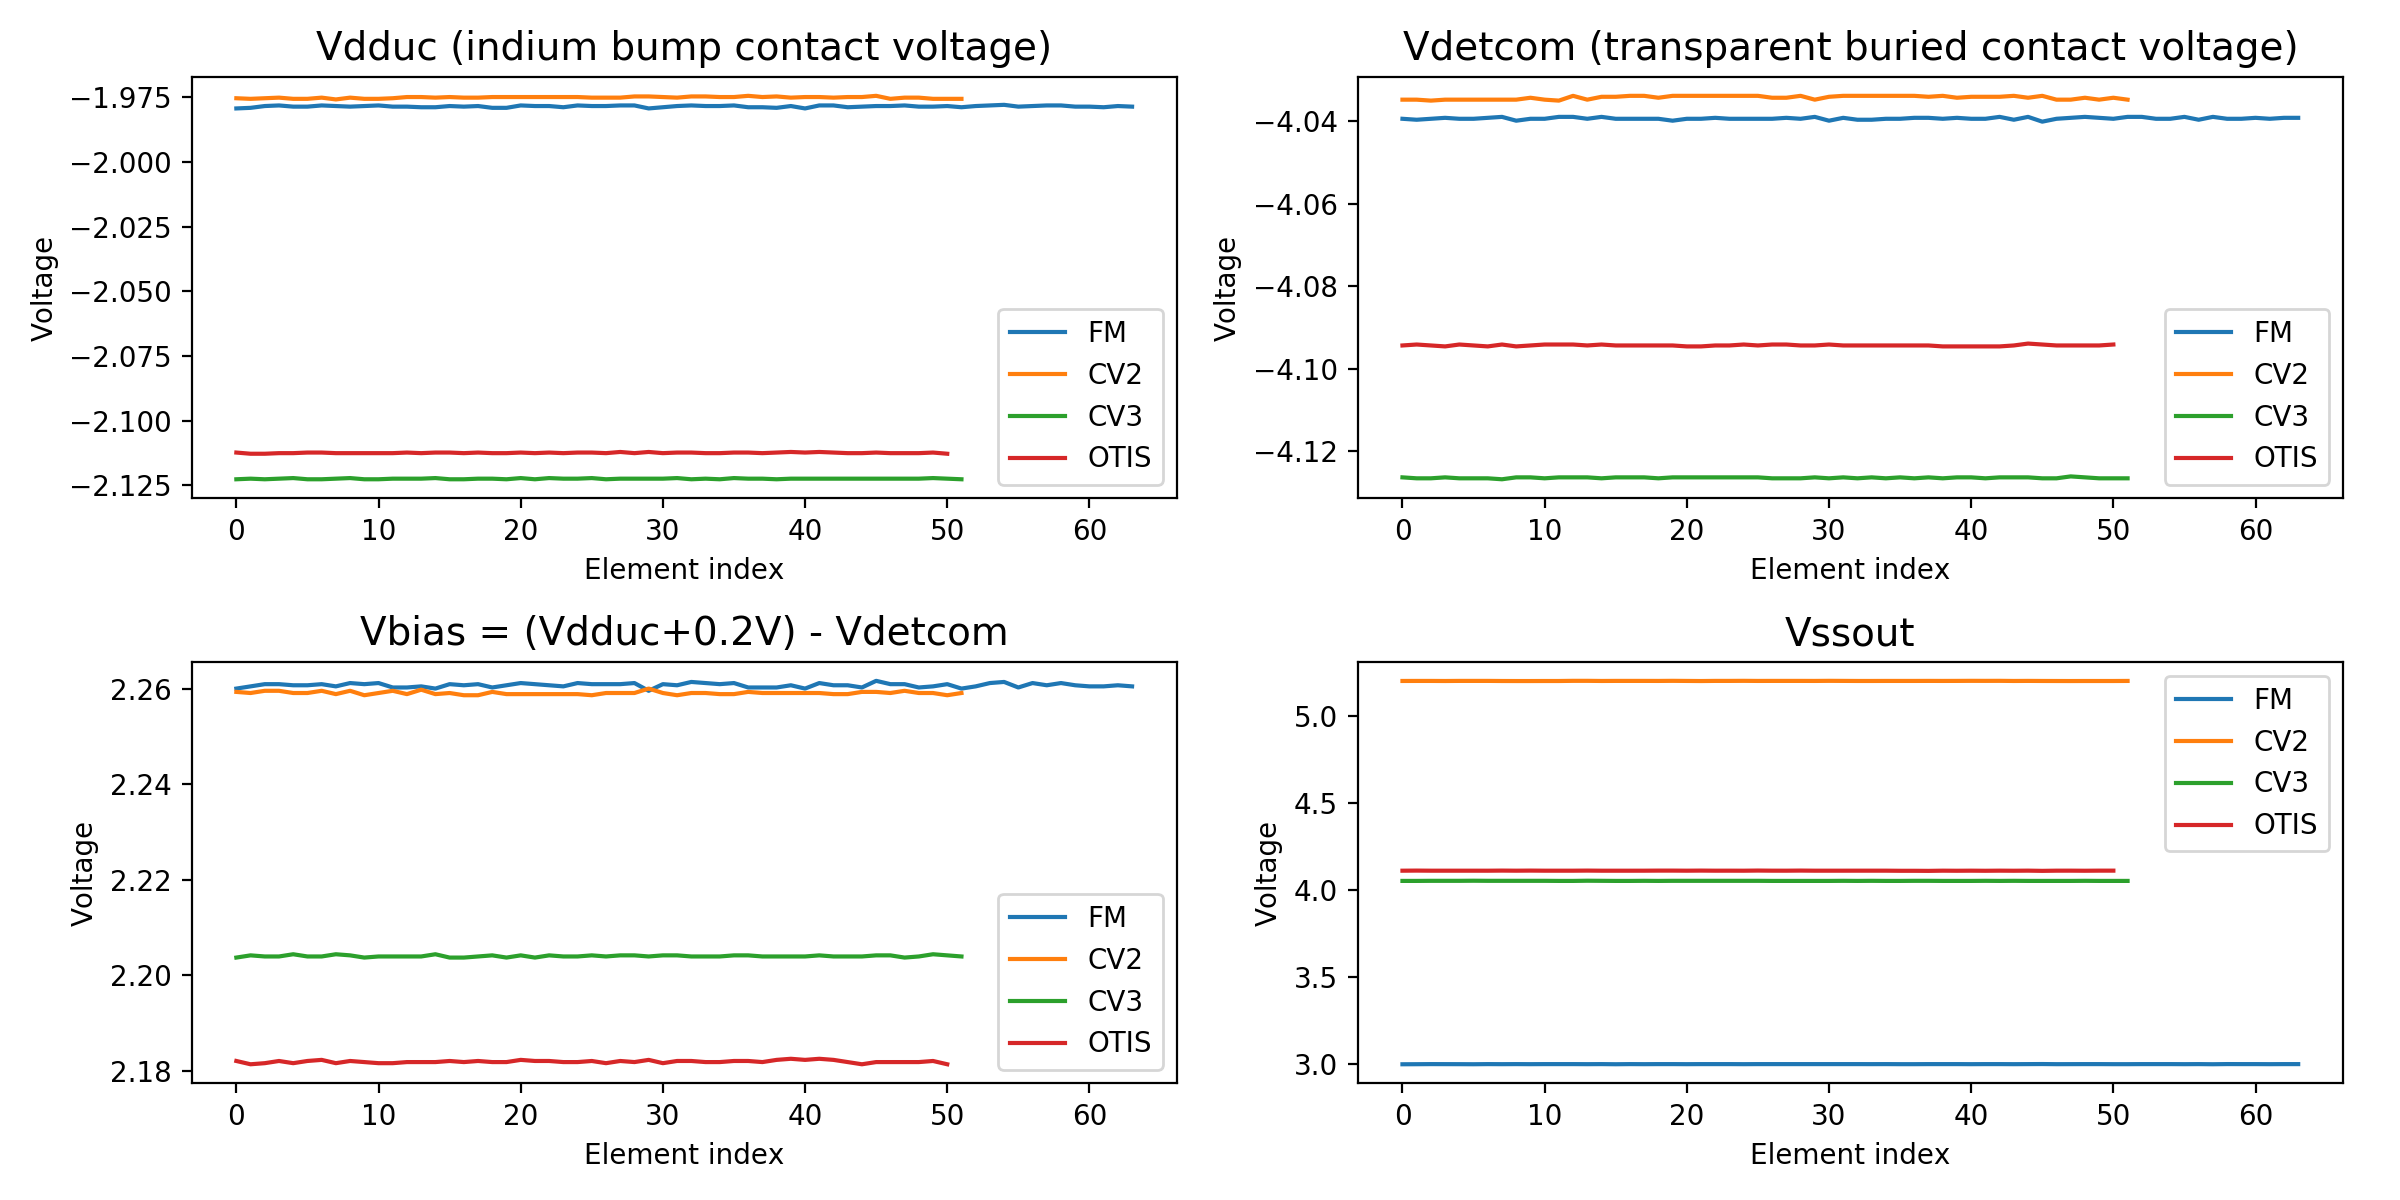

In [5]:
fig,axs = plt.subplots(2,2,figsize=(12,6))
for campaign in campaigns:
    axs[0,0].plot(VDDUC[campaign],label=campaign)
    axs[0,1].plot(VDETCOM[campaign],label=campaign)
    axs[1,0].plot(VBIAS[campaign],label=campaign)
    axs[1,1].plot(VSSOUT[campaign],label=campaign)
axs[0,0].set_title('Vdduc (indium bump contact voltage)',fontsize=14)
axs[0,1].set_title('Vdetcom (transparent buried contact voltage)',fontsize=14)
axs[1,0].set_title('Vbias = (Vdduc+0.2V) - Vdetcom',fontsize=14)
axs[1,1].set_title('Vssout',fontsize=14)
for i,j in itertools.product(range(2),range(2)):
    axs[i,j].set_xlabel('Element index')
    axs[i,j].set_ylabel('Voltage')
    axs[i,j].legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


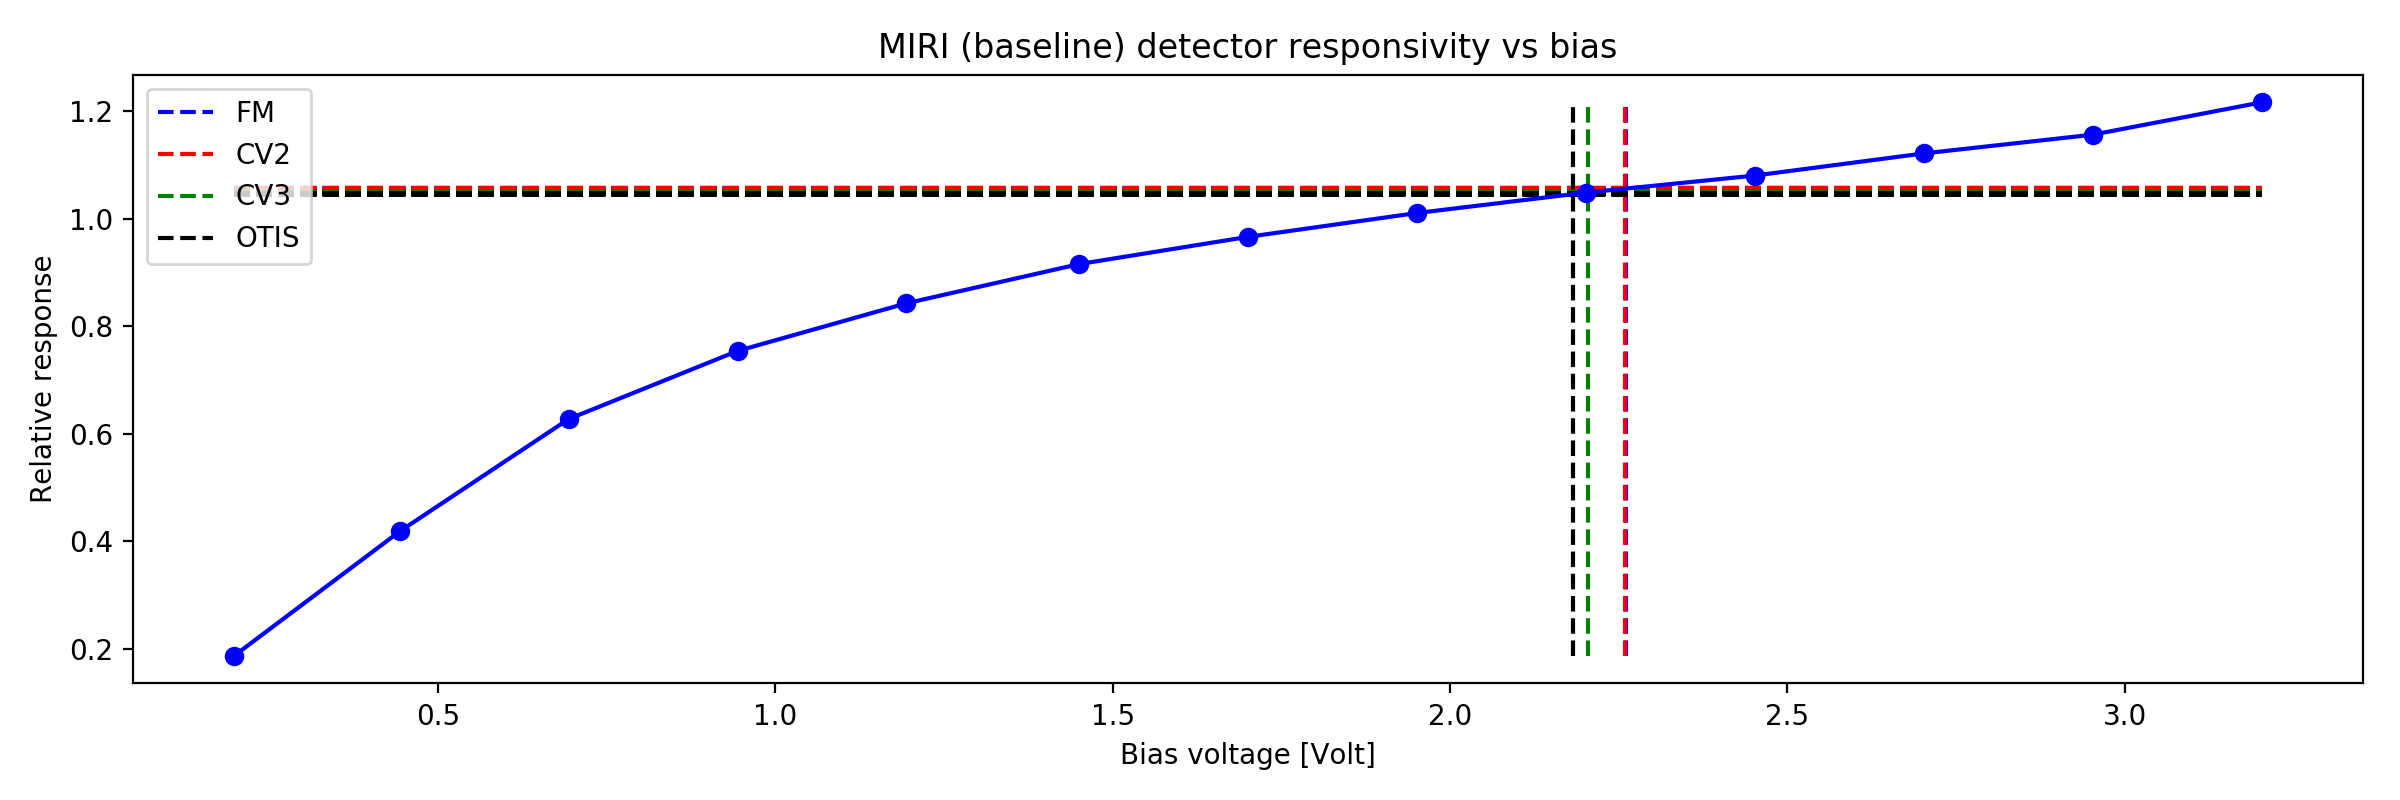

In [6]:
fname = 'Response_vs_BiasVoltage.csv'
bias_voltage,rel_response = np.loadtxt(fname, delimiter=',', usecols=(0,1), unpack=True)
interp = interp1d(bias_voltage,rel_response)

plt.figure(figsize=(12,4))
plt.plot(bias_voltage,rel_response,'bo')
plt.plot(bias_voltage,rel_response,'b')
colors =  ['b','r','g','k']
for i,campaign in enumerate(campaigns):
    plt.vlines(np.mean(VBIAS[campaign]),rel_response.min(),rel_response.max(),colors[i],linestyle='dashed',label=campaign)
    plt.hlines(interp(VBIAS[campaign]),bias_voltage.min(),bias_voltage.max(),colors[i],linestyle='dashed')
plt.xlabel('Bias voltage [Volt]')
plt.ylabel('Relative response')
plt.legend()
plt.title('MIRI (baseline) detector responsivity vs bias')
plt.tight_layout()

**Plot MIRI ramp image**

<IPython.core.display.Javascript object>


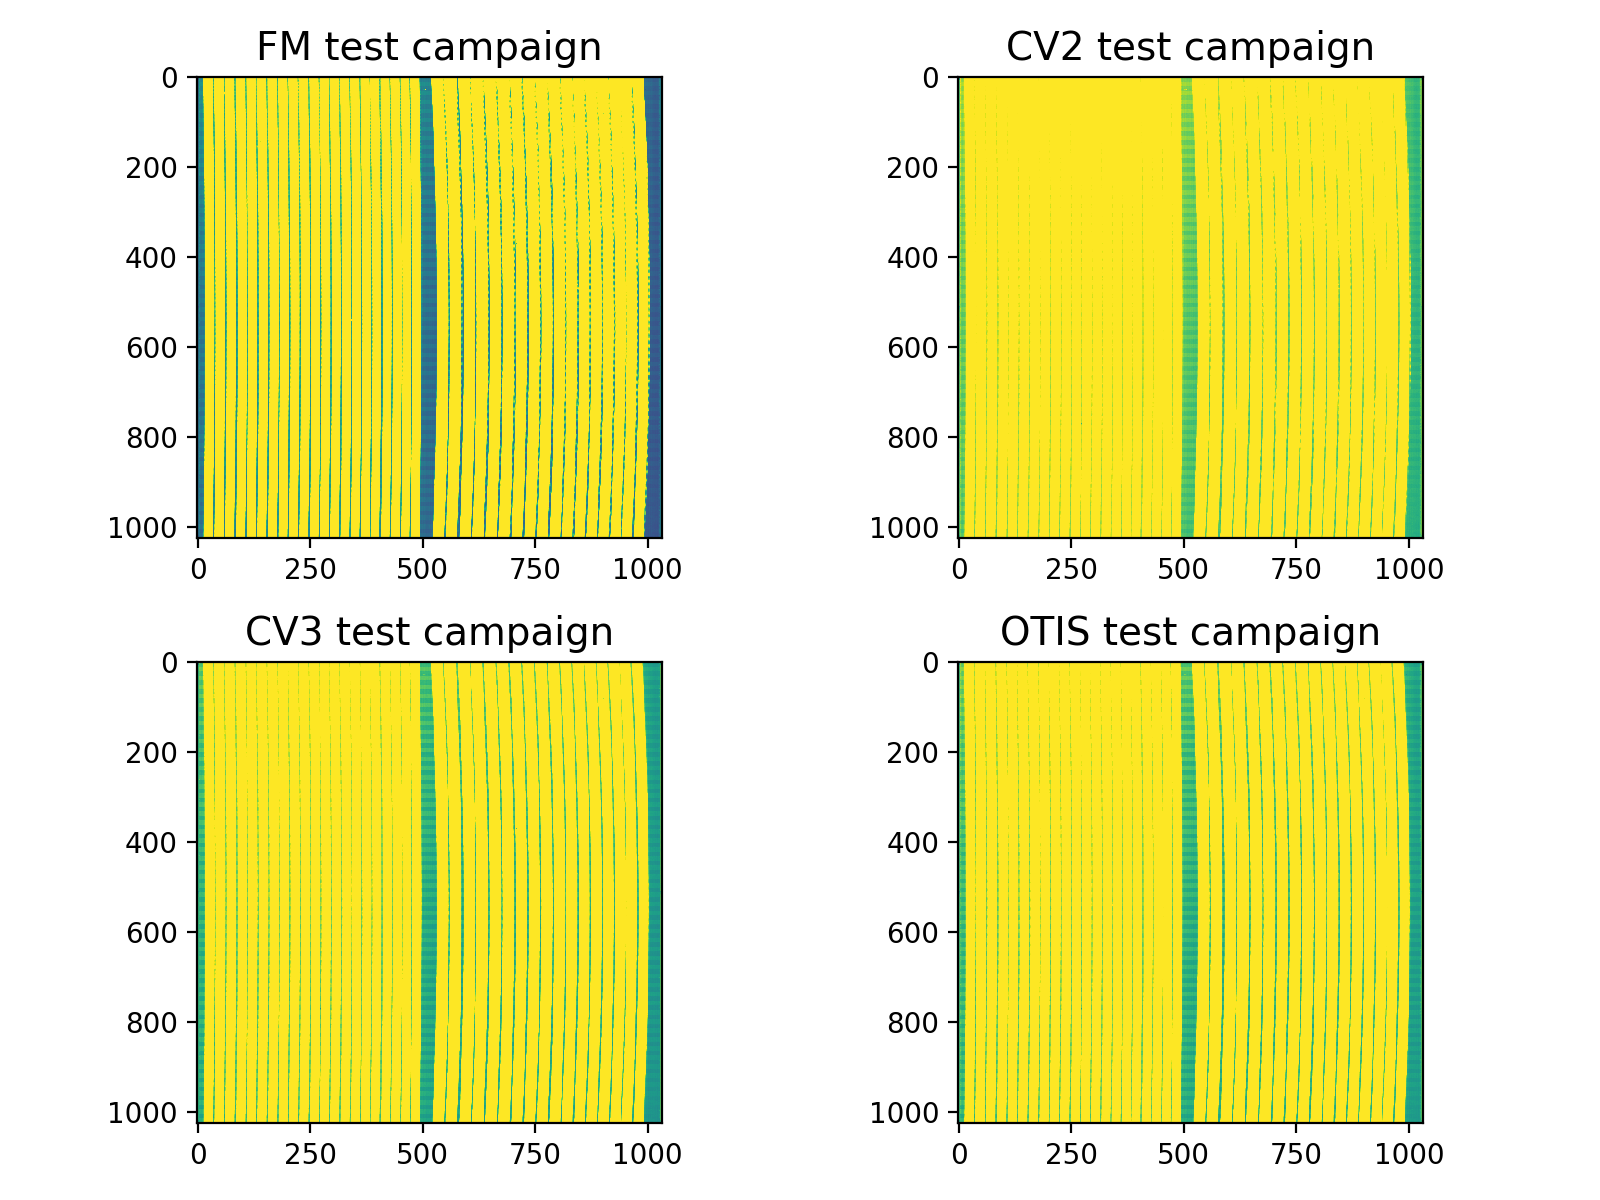

In [8]:
frame = 18
fig,axs = plt.subplots(2,2,figsize=(8,6))
axs[0,0].imshow(sci_exp_ramp['FM'][frame,:1024,:],vmin=0,vmax=20000)
axs[0,1].imshow(sci_exp_ramp['CV2'][frame,:1024,:],vmin=0,vmax=20000)
axs[1,0].imshow(sci_exp_ramp['CV3'][frame,:1024,:],vmin=0,vmax=20000)
axs[1,1].imshow(sci_exp_ramp['OTIS'][frame,:1024,:],vmin=0,vmax=20000)
axs[0,0].set_title('FM test campaign',fontsize=14)
axs[0,1].set_title('CV2 test campaign',fontsize=14)
axs[1,0].set_title('CV3 test campaign',fontsize=14)
axs[1,1].set_title('OTIS test campaign',fontsize=14)
plt.tight_layout()

**Plot MIRI slope image**

<IPython.core.display.Javascript object>


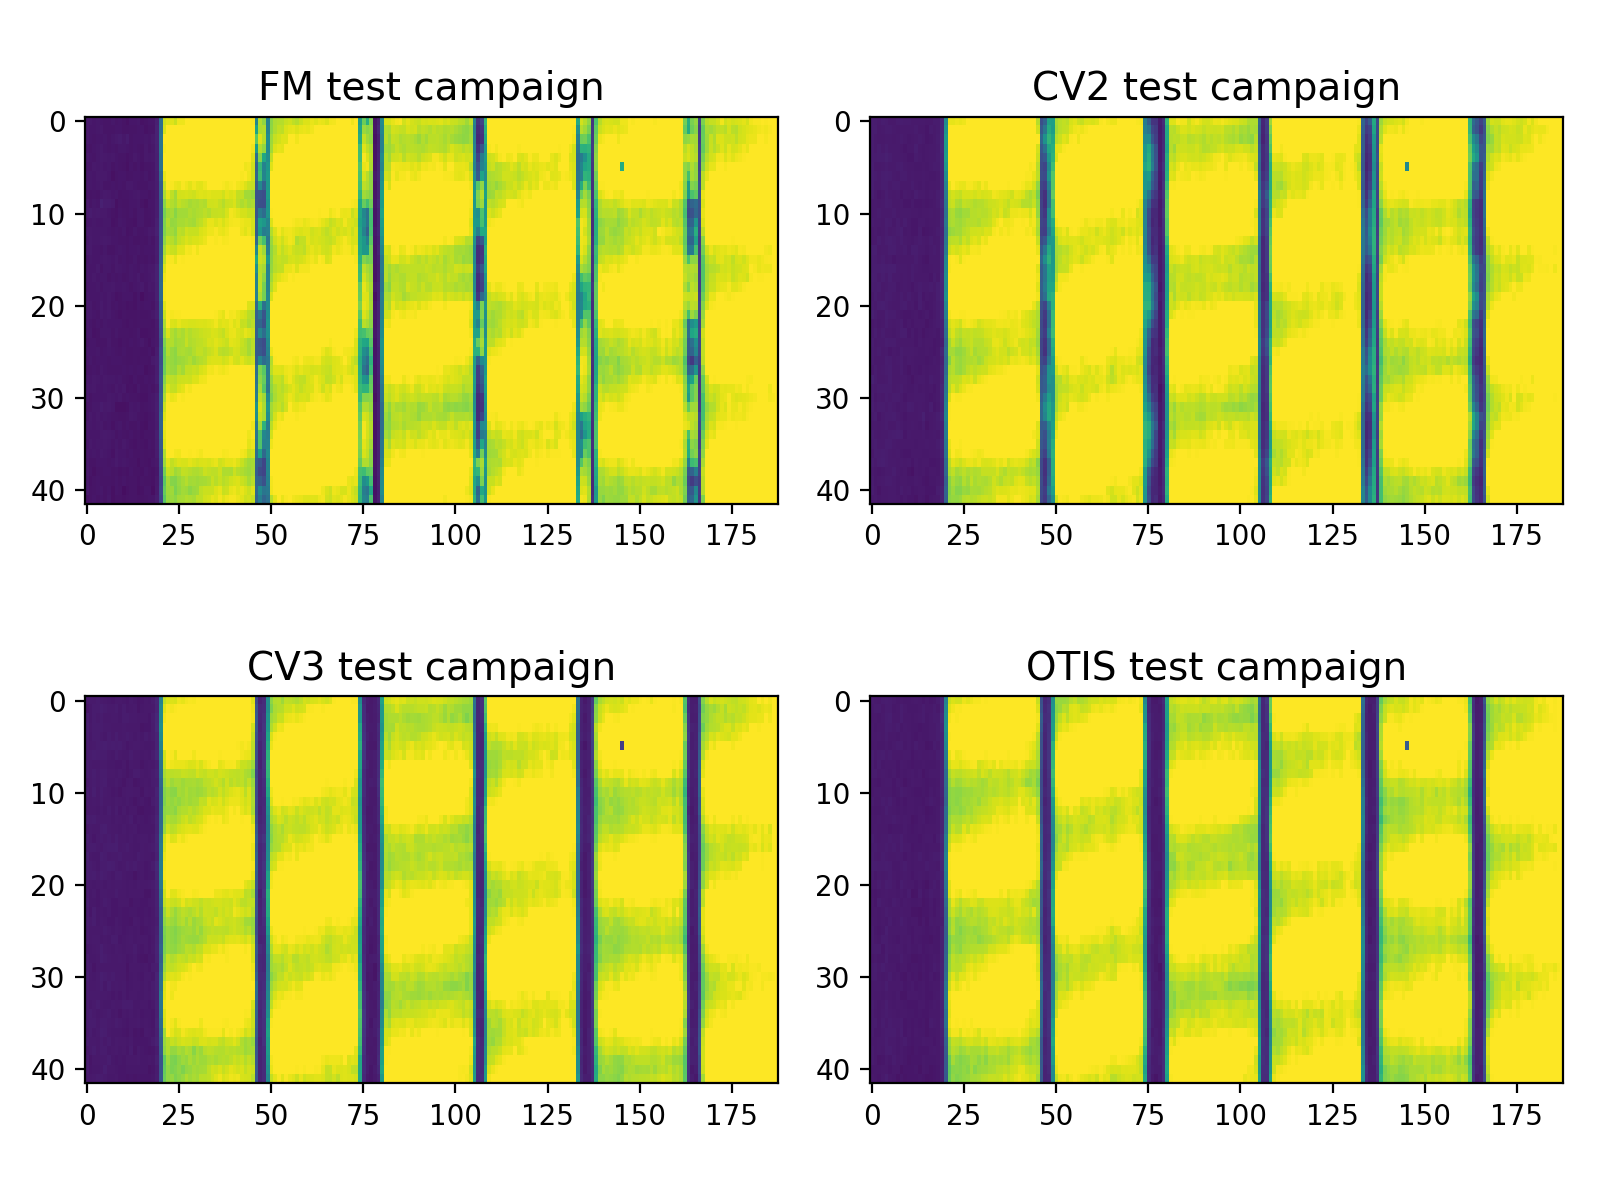

In [9]:
frame_1 = 17
frame_2 = 18
fig,axs = plt.subplots(2,2,figsize=(8,6))
axs[0,0].imshow((sci_exp_ramp['FM'][frame_2,480:522,512:700]-sci_exp_ramp['FM'][frame_1,480:522,512:700])/frame_delta_time['FM'],aspect=2.5,vmin=0,vmax=600)
axs[0,1].imshow((sci_exp_ramp['CV2'][frame_2,480:522,512:700]-sci_exp_ramp['CV2'][frame_1,480:522,512:700])/frame_delta_time['CV2'],aspect=2.5,vmin=0,vmax=600)
axs[1,0].imshow((sci_exp_ramp['CV3'][frame_2,480:522,512:700]-sci_exp_ramp['CV3'][frame_1,480:522,512:700])/frame_delta_time['CV3'],aspect=2.5,vmin=0,vmax=600)
axs[1,1].imshow((sci_exp_ramp['OTIS'][frame_2,480:522,512:700]-sci_exp_ramp['OTIS'][frame_1,480:522,512:700])/frame_delta_time['OTIS'],aspect=2.5,vmin=0,vmax=600)
axs[0,0].set_title('FM test campaign',fontsize=14)
axs[0,1].set_title('CV2 test campaign',fontsize=14)
axs[1,0].set_title('CV3 test campaign',fontsize=14)
axs[1,1].set_title('OTIS test campaign',fontsize=14)
plt.tight_layout()

**Let's look at the integration ramps for one pixel**

<IPython.core.display.Javascript object>


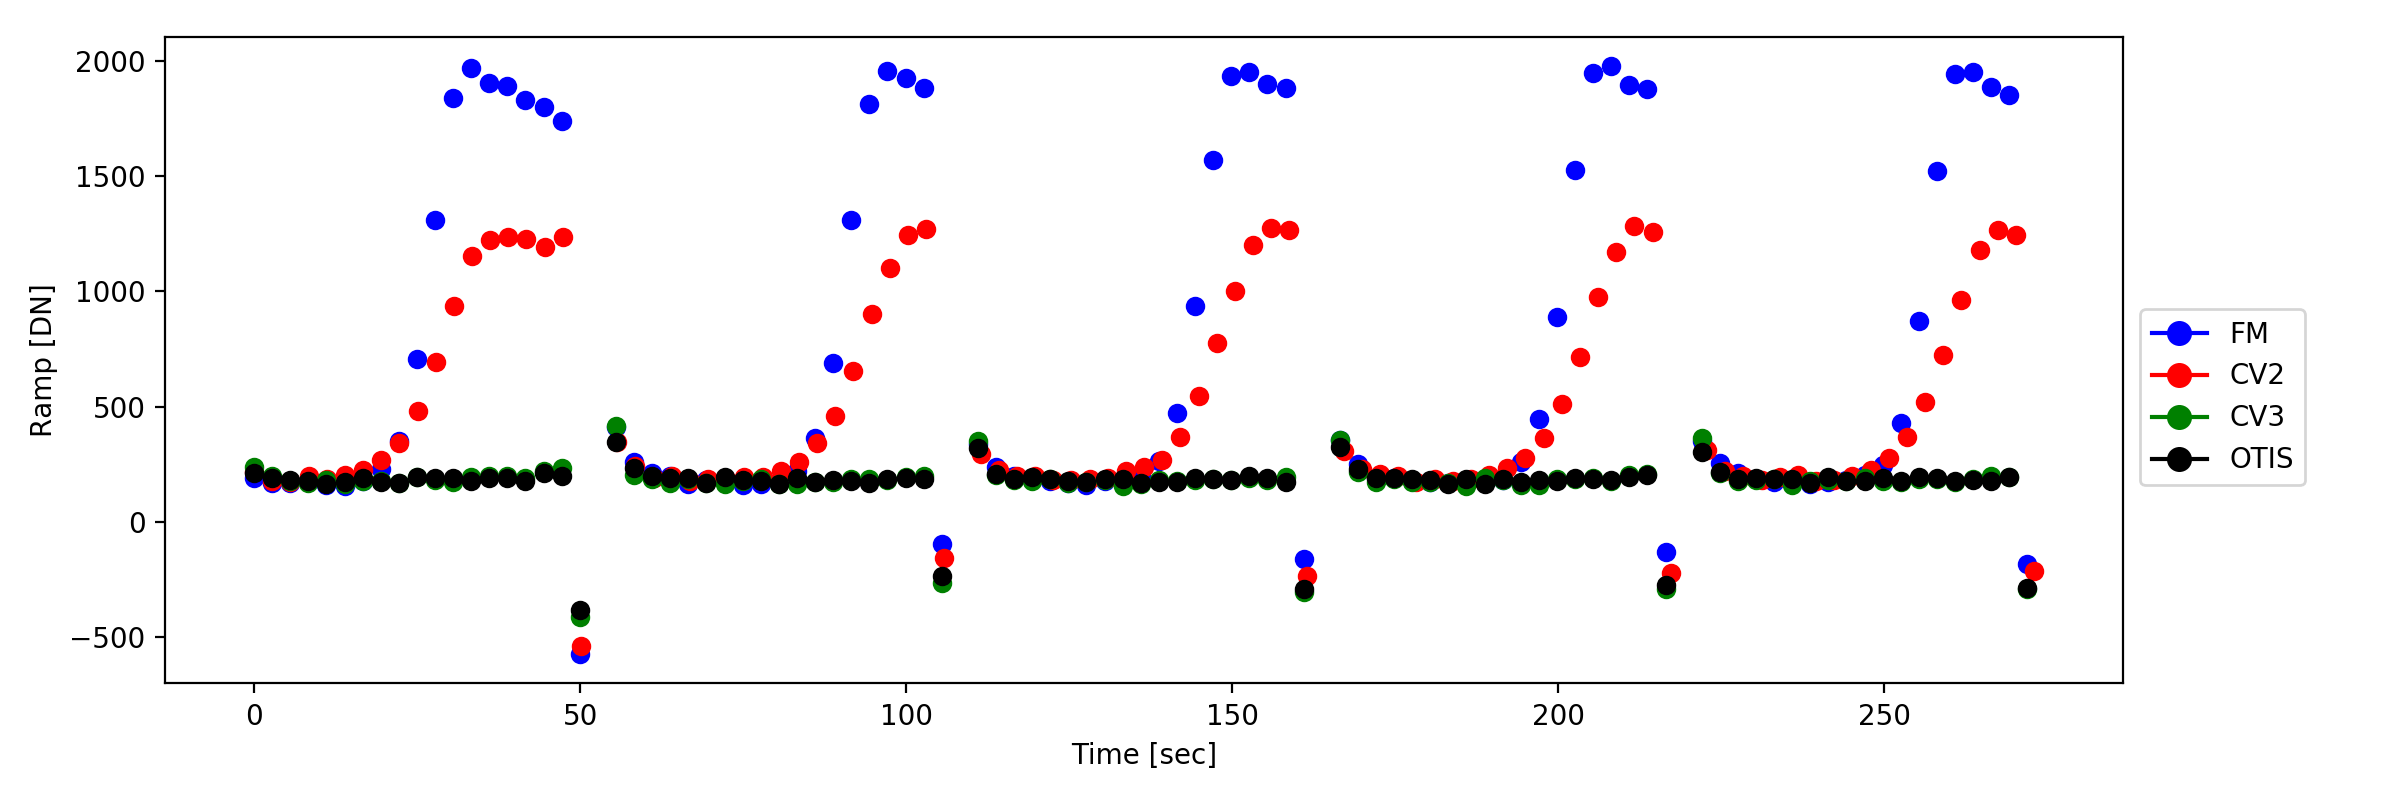

In [10]:
ypos,xpos = 320,816 # 810,1000
plt.figure(figsize=(12,4))
for j,campaign in enumerate(campaigns):
    for i in range(nints[campaign]):
        xdata  = np.arange(sci_exp_ramp[campaign].shape[0])[i*ngroups[campaign]:(i+1)*ngroups[campaign]]*frame_delta_time[campaign]
        ydata  = sci_exp_ramp[campaign][i*ngroups[campaign]:(i+1)*ngroups[campaign],ypos,xpos]

        plt.plot(xdata[:-1],np.diff(ydata),colors[j]+'o',label='INT {}'.format(i+1))
plt.xlabel('Time [sec]')
plt.ylabel('Ramp [DN]')
legend_elements = [Line2D([0],[0],marker='o',color='b',label='FM',markerfacecolor='b',markersize=8),
                   Line2D([0],[0],marker='o',color='r',label='CV2',markerfacecolor='r',markersize=8),
                   Line2D([0],[0],marker='o',color='g',label='CV3',markerfacecolor='g',markersize=8),
                   Line2D([0],[0],marker='o',color='k',label='OTIS',markerfacecolor='k',markersize=8)]
plt.legend(handles=legend_elements,bbox_to_anchor=(1.1,0.6))
plt.tight_layout(rect=[0,0,0.9,1])

<IPython.core.display.Javascript object>


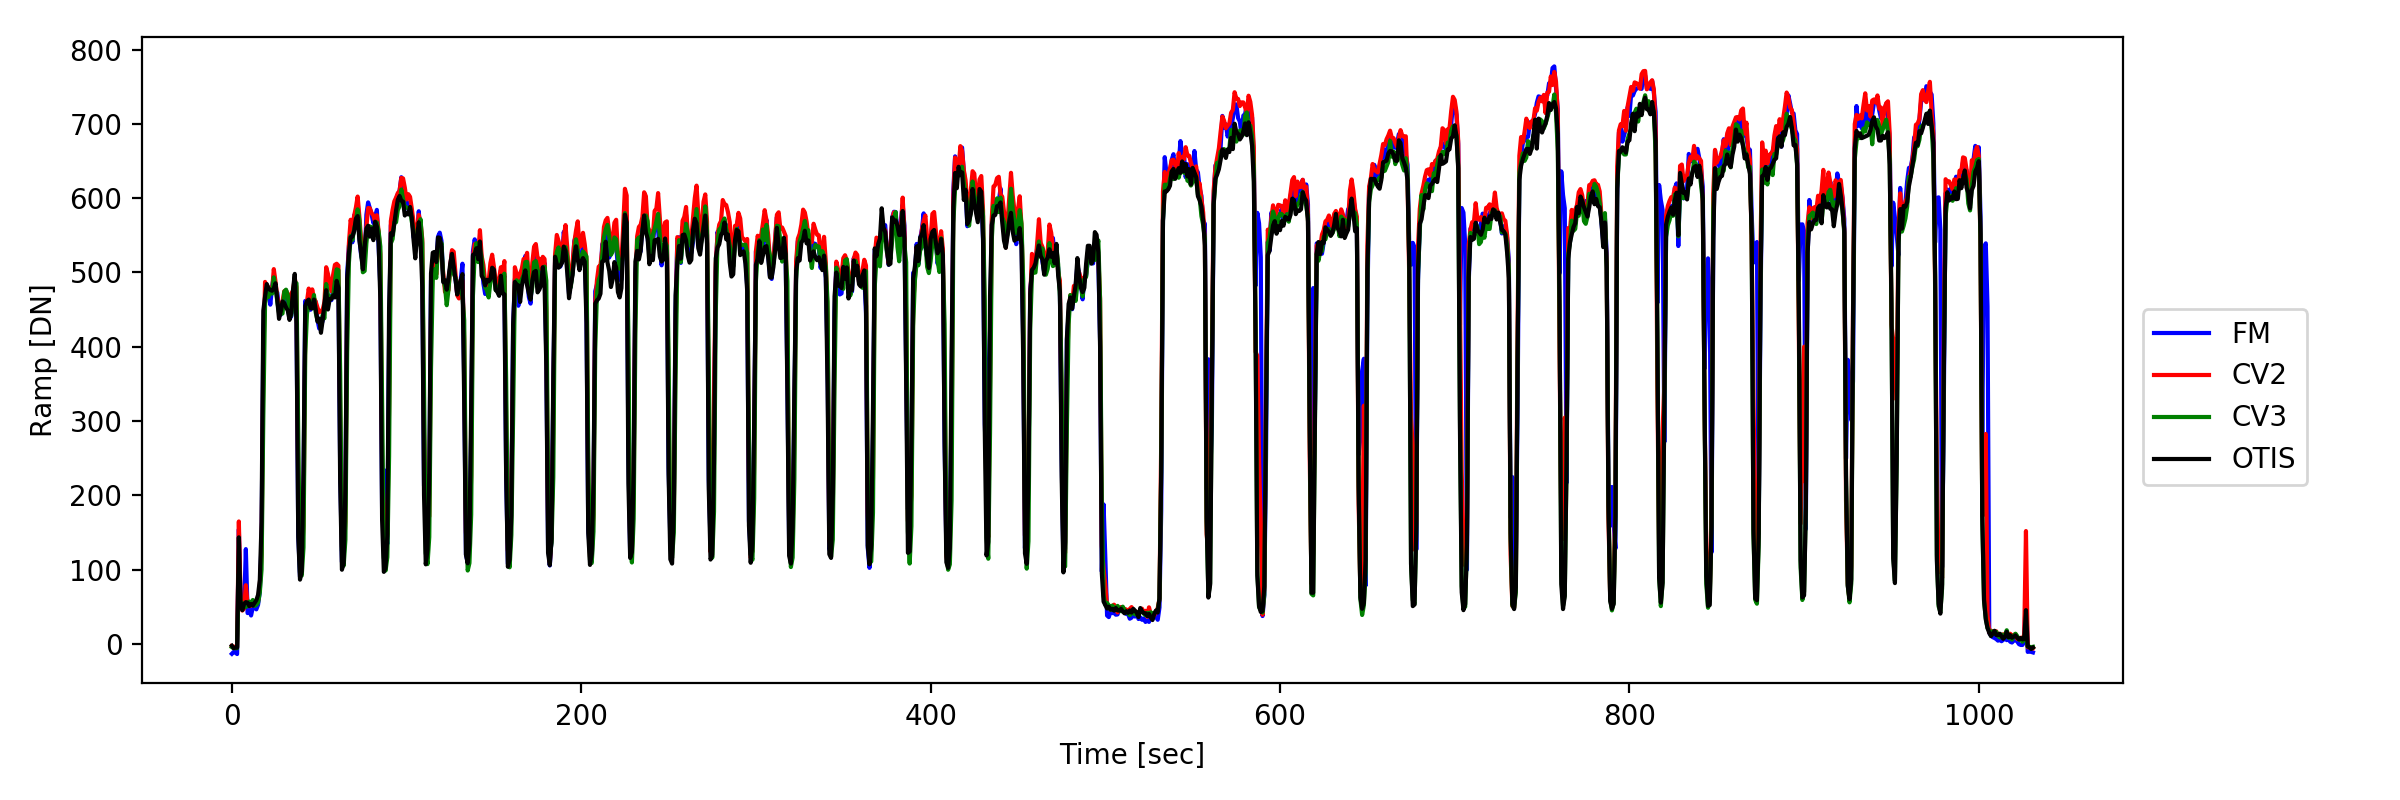

In [11]:
row = 500
plt.figure(figsize=(12,4))
for i,campaign in enumerate(campaigns):
#     xdata  = np.arange(512) # np.arange(520)
#     ydata  = (sci_exp_ramp[campaign][ngroups[campaign]-2,row,:512]-sci_exp_ramp[campaign][ngroups[campaign]-3,row,:512])/frame_delta_time[campaign]

    xdata  = np.arange(1032)
    ydata  = (sci_exp_ramp[campaign][ngroups[campaign]-2,row,:]-sci_exp_ramp[campaign][ngroups[campaign]-3,row,:])/frame_delta_time[campaign]
    
    plt.plot(xdata,ydata,colors[i],label='{} test campaign'.format(campaign))
plt.xlabel('Time [sec]')
plt.ylabel('Ramp [DN]')
legend_elements = [Line2D([0],[0],color='b',label='FM'),
                   Line2D([0],[0],color='r',label='CV2'),
                   Line2D([0],[0],color='g',label='CV3'),
                   Line2D([0],[0],color='k',label='OTIS')]
plt.legend(handles=legend_elements,bbox_to_anchor=(1.1,0.6))
plt.tight_layout(rect=[0,0,0.9,1])

<IPython.core.display.Javascript object>


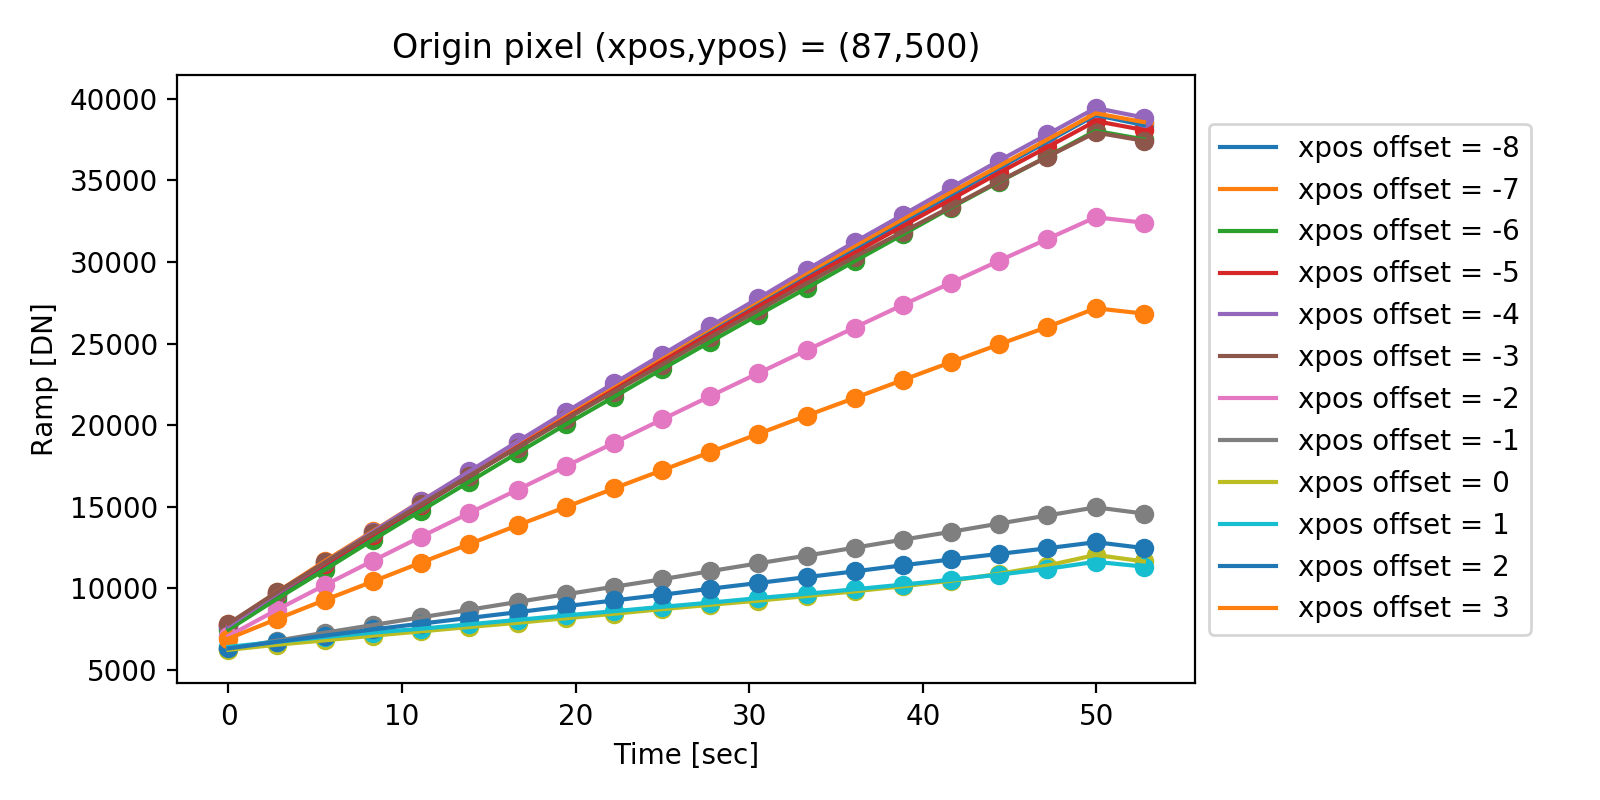

In [13]:
ypos,xpos = 500,87 # 320,815 #810,1000
campaign = 'FM'
plt.figure(figsize=(8,4))
for i in range(-8,4):
    xdata  = np.arange(sci_exp_ramp[campaign].shape[0])[:ngroups[campaign]]*frame_delta_time[campaign]
    ydata  = sci_exp_ramp[campaign][:ngroups[campaign],ypos,xpos+i]

    plt.scatter(xdata,ydata)
    plt.plot(xdata,ydata,label='xpos offset = {}'.format(i))
plt.xlabel('Time [sec]')
plt.ylabel('Ramp [DN]')
plt.title('Origin pixel (xpos,ypos) = ({},{})'.format(xpos,ypos))
plt.legend(loc='center left',fontsize=10,bbox_to_anchor=(1, 0.5))
plt.tight_layout(rect=[0,0,0.77,1])

<IPython.core.display.Javascript object>


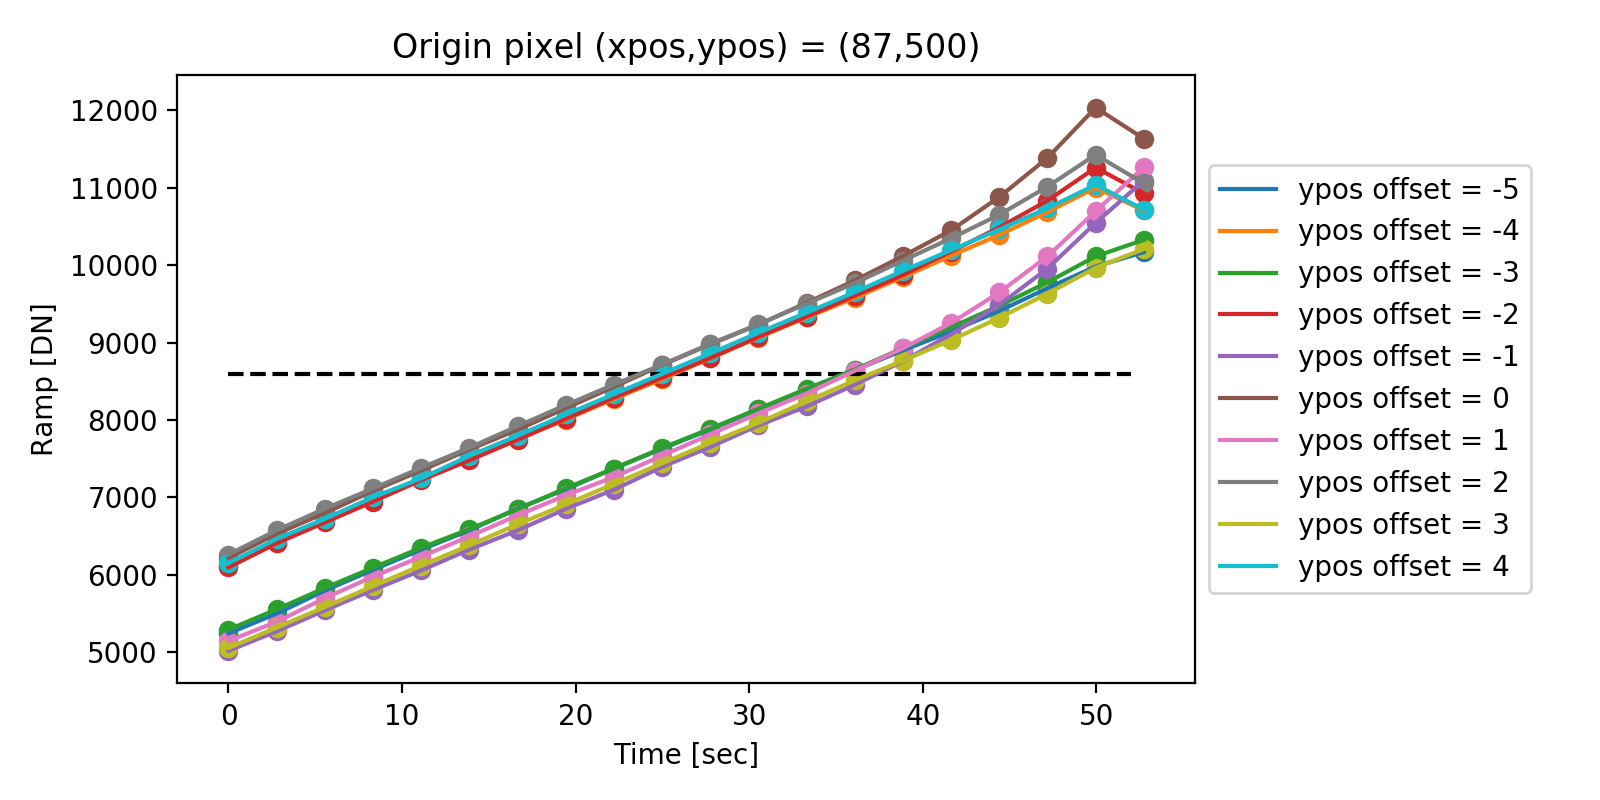

<IPython.core.display.Javascript object>


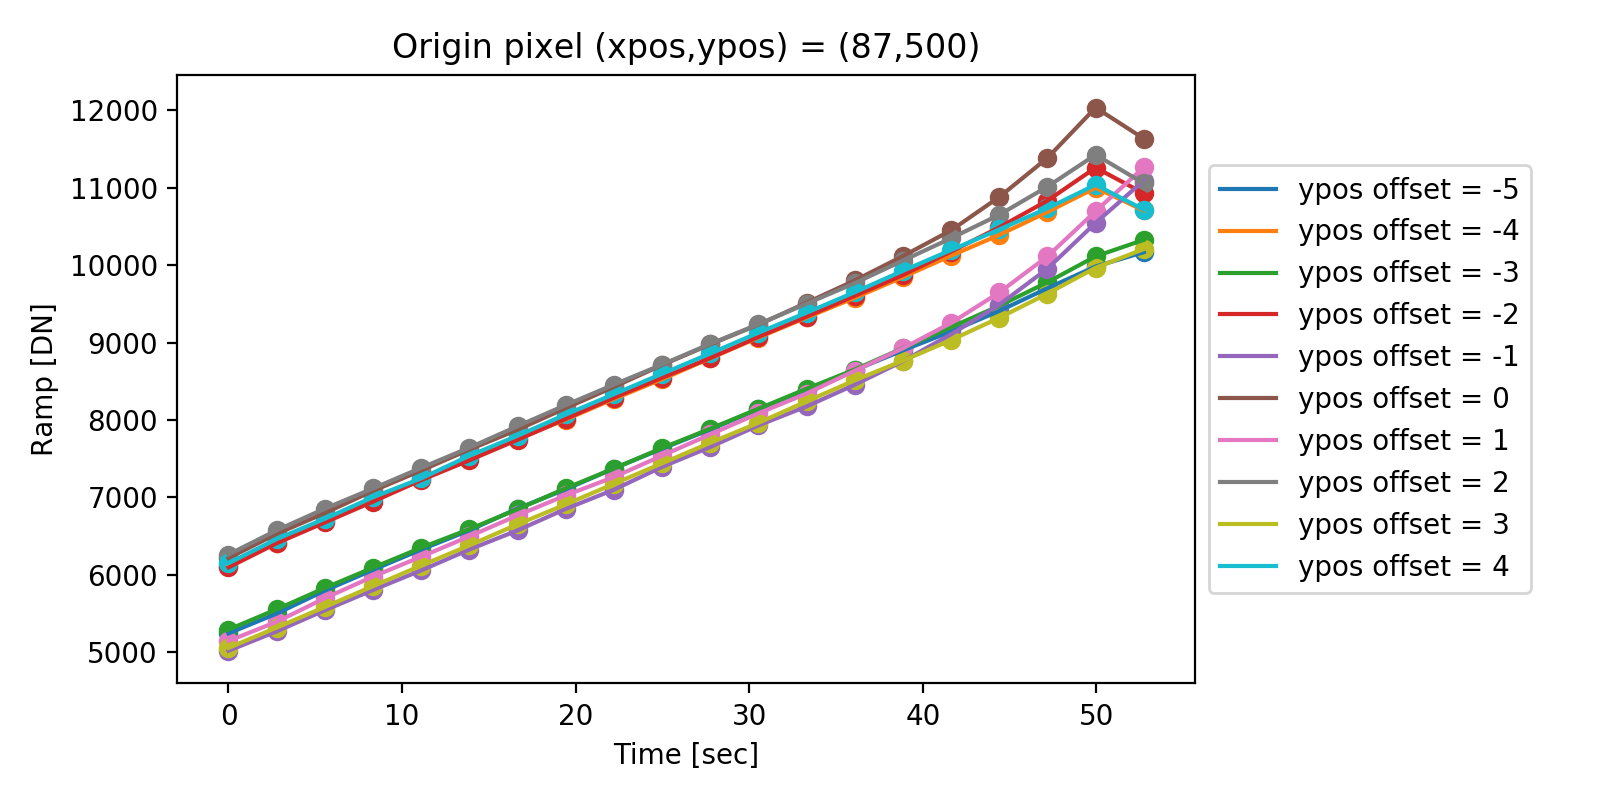

In [17]:
ypos,xpos = 500,87 # 320,815 # 810,1000
plt.figure(figsize=(8,4))
for i in range(-5,5):
    xdata  = np.arange(sci_exp_ramp[campaign].shape[0])[:ngroups[campaign]]*frame_delta_time[campaign]
    ydata  = sci_exp_ramp[campaign][:ngroups[campaign],ypos+i,xpos]

    plt.scatter(xdata,ydata)
    plt.plot(xdata,ydata,label='ypos offset = {}'.format(i))
plt.hlines(8600,0,52,'k',linestyle='dashed')
plt.xlabel('Time [sec]')
plt.ylabel('Ramp [DN]')
plt.title('Origin pixel (xpos,ypos) = ({},{})'.format(xpos,ypos))
plt.legend(loc='center left',fontsize=10,bbox_to_anchor=(1, 0.5))
plt.tight_layout(rect=[0,0,0.77,1])

ypos,xpos = 500,87 # 320,814 # 810,1000
plt.figure(figsize=(8,4))
for i in range(-5,5):
    xdata  = np.arange(sci_exp_ramp[campaign].shape[0])[:ngroups[campaign]]*frame_delta_time[campaign]
    ydata  = sci_exp_ramp[campaign][:ngroups[campaign],ypos+i,xpos]

    plt.scatter(xdata,ydata)
    plt.plot(xdata,ydata,label='ypos offset = {}'.format(i))
plt.xlabel('Time [sec]')
plt.ylabel('Ramp [DN]')
plt.title('Origin pixel (xpos,ypos) = ({},{})'.format(xpos,ypos))
plt.legend(loc='center left',fontsize=10,bbox_to_anchor=(1, 0.5))
plt.tight_layout(rect=[0,0,0.77,1])